# Realtime ASR

Let say you want to transcribe realtime recording / input using PyAudio, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-asr](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-asr).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [2]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
/Users/huseinzolkepli/.pyenv/versions/3.9.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchaudio.io.StreamReader exception: FFmpeg libraries are not found. Please install FFmpeg.
`torchaudio.io.StreamReader` is not available, `malaya_speech.streaming.torchaudio.stream` is not able to use.
`openai-whisper` is not available, native whisper processor is not available, will use huggingface processor instead.
`torchaudio.io.StreamReader` is not available, `

### Load VAD model

We are going to use WebRTC VAD model, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [3]:
vad_model = malaya_speech.vad.webrtc()

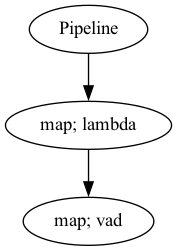

In [4]:
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

Starting malaya-speech 1.4.0, streaming always returned a float32 array between -1 and +1 values.

### Streaming interface

```python
def stream(
    vad_model=None,
    asr_model=None,
    classification_model=None,
    sample_rate: int = 16000,
    segment_length: int = 2560,
    num_padding_frames: int = 20,
    ratio: float = 0.75,
    min_length: float = 0.1,
    max_length: float = 10.0,
    realtime_print: bool = True,
    **kwargs,
):
    """
    Stream an audio using pyaudio library.

    Parameters
    ----------
    vad_model: object, optional (default=None)
        vad model / pipeline.
    asr_model: object, optional (default=None)
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object, optional (default=None)
        classification pipeline, will classify each subsamples realtime.
    device: None, optional (default=None)
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    segment_length: int, optional (default=2560)
        usually derived from asr_model.segment_length * asr_model.hop_length,
        size of audio chunks, actual size in term of second is `segment_length` / `sample_rate`.
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (second) to accept a subsample.
    max_length: float, optional (default=10.0)
        maximum length (second) to accept a subsample.
    realtime_print: bool, optional (default=True)
        Will print results for ASR.
    **kwargs: vector argument
        vector argument pass to malaya_speech.streaming.pyaudio.Audio interface.

    Returns
    -------
    result : List[dict]
    """
```

### Check available devices

In [5]:
import sounddevice

sounddevice.query_devices()

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

By default it will use `0` index.

### Load ASR model

In [6]:
malaya_speech.stt.transducer.available_pt_transformer()

{'mesolitica/conformer-tiny': {'Size (MB)': 38.5,
  'malay-malaya': {'WER': 0.17341180814, 'CER': 0.05957485024},
  'malay-fleur102': {'WER': 0.19524478979, 'CER': 0.0830808938},
  'Language': ['malay']},
 'mesolitica/conformer-base': {'Size (MB)': 121,
  'malay-malaya': {'WER': 0.122076123261, 'CER': 0.03879606324},
  'malay-fleur102': {'WER': 0.1326737206665, 'CER': 0.05032914857},
  'Language': ['malay']},
 'mesolitica/conformer-medium': {'Size (MB)': 121,
  'malay-malaya': {'WER': 0.1375828607, 'CER': 0.04320797311},
  'malay-fleur102': {'WER': 0.1430281008, 'CER': 0.05527847917},
  'Language': ['malay']},
 'mesolitica/emformer-base': {'Size (MB)': 162,
  'malay-malaya': {'WER': 0.18048993533, 'CER': 0.064647787727},
  'malay-fleur102': {'WER': 0.19121038729, 'CER': 0.08266033385},
  'Language': ['malay']}}

In [7]:
model = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-base')

In [8]:
_ = model.eval()

### ASR Pipeline

Feel free to add speech enhancement or any function, but in this example, I just keep it simple.

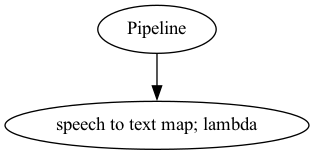

In [9]:
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(lambda x: model.beam_decoder([x])[0], name = 'speech-to-text')
)
p_asr.visualize()

**You need to make sure the last output should named as `speech-to-text` or else the streaming interface will throw an error**.

### Start Recording

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [10]:
samples = malaya_speech.streaming.pyaudio.stream(vad_model = p_vad, asr_model = p_asr,
                                                segment_length = 320)

helo nama saya send beyzol caple hussein bin zon aplikasi hussein benzool kaply okeylah tu ceritanya satu hari saya terjumpa sang kancil sahkan check tu kecil ya saya dia dan sangat comel itu jah terima kasih 

In [11]:
samples

[{'wav_data': array([0.00011471, 0.00038795, 0.00036059, ..., 0.00127992, 0.00122857,
         0.00120794], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 0, 0, 9, 624554),
  'asr_model': 'helo'},
 {'wav_data': array([0.00070306, 0.00080921, 0.00047682, ..., 0.000828  , 0.00085896,
         0.00070666], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 0, 0, 11, 764225),
  'asr_model': 'nama saya'},
 {'wav_data': array([-1.03867212e-02,  1.49657875e-02, -1.39974728e-02, ...,
         -1.20115852e-04, -8.13784718e-05, -2.11482384e-05], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 0, 0, 13, 743926),
  'asr_model': 'send'},
 {'wav_data': array([-0.00010118, -0.00034931, -0.0004679 , ..., -0.00115305,
         -0.00099543, -0.00089371], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 0, 0, 15, 804238),
  'asr_model': 'beyzol caple'},
 {'wav_data': array([-0.0009796 , -0.00115869, -0.00147092, ...,  0.00075836,
          0.00080503, 

Actually it is pretty nice. As you can see, it able to transcribe realtime, you can try it by yourself.

In [12]:
len(samples)

18

In [13]:
samples[-1]

{'wav_data': array([1.8315334e-03, 2.6453051e-03, 1.7561917e-03, ..., 8.3418025e-05,
        3.1597860e-04, 4.9989566e-04], dtype=float32),
 'timestamp': datetime.datetime(2023, 2, 16, 0, 0, 54, 264416),
 'asr_model': 'terima kasih'}

In [14]:
import IPython.display as ipd
import numpy as np

In [15]:
ipd.Audio(samples[-1]['wav_data'], rate = 16000)

In [17]:
ipd.Audio(np.concatenate([s['wav_data'] for s in samples]), rate = 16000)